# SAM2-全局分割预测+掩码输出

## 导入图像并添加坐标轴输出

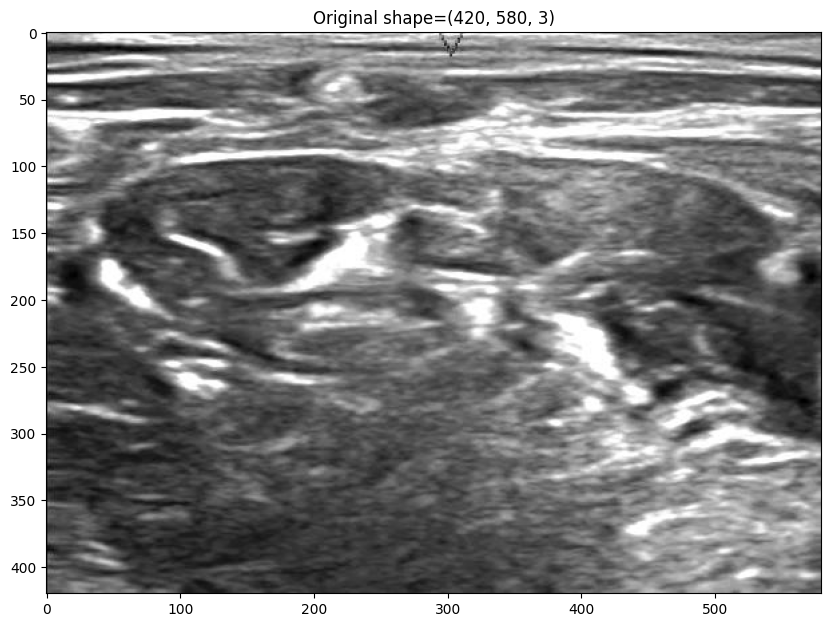

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))
        
image = cv2.imread('./pics/ultrasound-nerve.jpg')
# 还原原图像色彩
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title(f"Original shape={image.shape}")
plt.axis('on')
plt.show()

## 导入所需库及模型部分

In [7]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import torch

# 选择运行设备
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        
checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64, # 表示在图像的每一侧生成 64 个采样点（即一个 64x64 的网格，共 4096 个点），用于计算掩码。这些点均匀分布在图像上，影响掩码生成的精度
    points_per_batch=128, # 指定在每批处理中使用 128 个点。这决定了模型在每次推理过程中使用多少个点进行掩码预测，影响处理速度与显存占用
    pred_iou_thresh=0.7, # 设定预测的交并比（IoU）阈值，表示生成的掩码需要与真实掩码的 IoU 大于 0.7 才会被认为是有效的掩码。这控制了掩码的准确性
    stability_score_thresh=0.92, # 掩码稳定性分数的阈值。该分数评估掩码在不同情况下的稳定性（即形状是否保持一致）。只有稳定性分数高于 0.92 的掩码才会被保留，确保生成的掩码具有较高的质量
    stability_score_offset=0.7, # 对稳定性分数应用的偏移量，用于调节生成掩码时的稳定性计算。通过偏移值调整，可以影响对掩码稳定性的判断
    crop_n_layers=1, # 指定用于裁剪图像的层数。值越大，表示裁剪的区域越多。通过层数裁剪，可以对图像不同区域进行精细掩码生成
    box_nms_thresh=0.7, # 使用非极大值抑制（NMS）去除重叠区域时的阈值。如果两个候选掩码的边界框重叠度（IoU）超过 0.7，则移除置信度较低的掩码，确保最终结果中没有过多的重复区域
    crop_n_points_downscale_factor=2, # 裁剪过程中用于缩放点数的比例。设置为 2 表示在裁剪的图像块上，采样点的数量减少一半。这个参数用于加快裁剪区域的处理
    min_mask_region_area=25, # 最小掩码区域的面积。小于 25 像素的掩码区域会被过滤掉，避免生成过小或噪声掩码
    use_m2m=True, # 指定是否使用 m2m 方法（Mask-to-Mask）。启用后，可能会使用现有掩码之间的关系来生成新的掩码，从而提高掩码生成的效率和质量
)

using device: cuda


## 使用模型预测并输出可视化结果

/home/ubuntu/桌面/20240910-SVM/venv/lib/python3.12/site-packages/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/ubuntu/桌面/20240910-SVM/venv/lib/python3.12/site-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


len(mask)=41
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


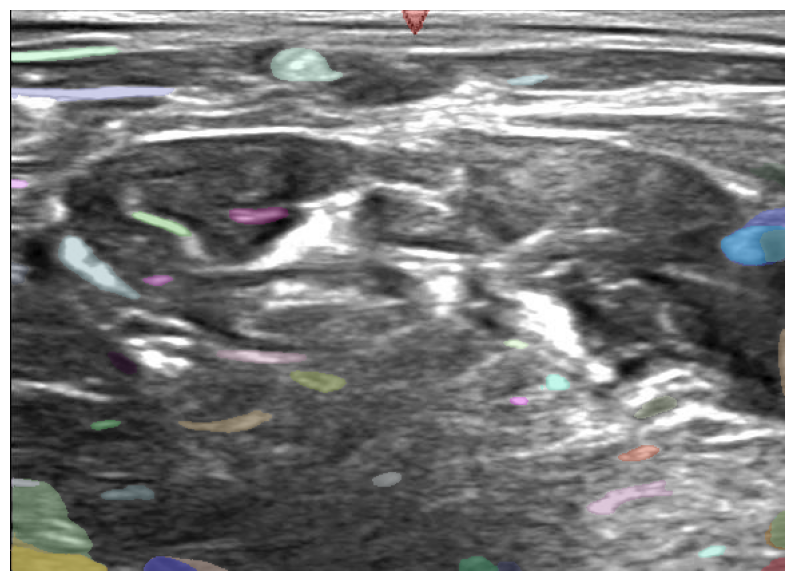

In [8]:
masks = mask_generator_2.generate(image)
print(f"len(mask)={len(masks)}") # 产生的掩码数量
print(masks[0].keys()) # 第1个掩码内的相关属性

plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 